# **Part I**

# **InceptionV3**


# **Step 1. Data Preprocessing**



In [ ]:
# TensorFlow is the most widely used library in developing deep learning models. 
# Many developers use TensorFlow in their sensitive and advanced projects. 
# One of the main reasons for TensorFlow's popularity is its open source. 
# Tensorflow is superior to other libraries in numerical calculations, which is one of the most vital needs of deep learning. 
# TensorFlow combines machine learning and deep learning (aka neural networks) models and algorithms and transforms them into a useful and usable form.

from tensorflow.keras.preprocessing.image import ImageDataGenerator # This line imports the ImageDataGenerator class from TensorFlow's Keras API. ImageDataGenerator is used for real-time data augmentation and preprocessing of image data.
import tensorflow as tf # This line imports TensorFlow, a powerful library for numerical computing and machine learning, particularly deep learning.

# Load Data: Use Keras' ImageDataGenerator to load images. 
# This class also allows you to perform data augmentation which is helpful for generalizing the model. 
# Preprocess Data: InceptionV3 requires specific input preprocessing. F
# ortunately, Keras provides a function for this: tensorflow.keras.applications.inception_v3.preprocess_input.

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)
# Here, an instance of ImageDataGenerator is created named train_datagen. 
# This is configured to preprocess images according to the preprocessing needs of the InceptionV3 model. 
# The preprocess_input function specific to InceptionV3 is used to ensure that input images are properly scaled and normalized for the model.

train_data_dir = '/content/train/train'
validation_data_dir = '/content/validation/validation'
# These lines define the file paths for the training and validation datasets, respectively.

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical')
# This creates a generator (train_generator) that will read images from the directory specified in train_data_dir, preprocess them, and yield batches of images and labels for training.
# target_size=(299, 299) sets the dimensions to which all images found will be resized, as InceptionV3 requires inputs of this size.
# batch_size=32 specifies the number of images to yield in each batch.
# class_mode='categorical' indicates that labels are to be one-hot encoded, which is a common format for categorical classification.


validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')
# Similar to train_generator, this creates a generator for validation data (validation_generator). 
# It reads images from validation_data_dir, preprocesses them, and yields them in batches.
# The parameters are the same as for the training generator, ensuring consistency in how training and validation images are processed.

Found 22348 images belonging to 22 classes.
Found 4800 images belonging to 22 classes.


# **Step 2. Load the InceptionV3 Model**



In [ ]:
# Load InceptionV3 from Keras applications. 
# Set include_top to False to exclude the final fully connected layer, as you will be adding your own for the 22 classes.

from tensorflow.keras.applications import InceptionV3 # This line imports the InceptionV3 model from TensorFlow's Keras applications module. InceptionV3 is a popular convolutional neural network architecture used for image classification.

base_model = InceptionV3(weights='imagenet', include_top=False) 
# base_model is initialized as an instance of the InceptionV3 model.
# weights='imagenet' indicates that the model should be loaded with weights pre-trained on ImageNet, a large visual database used for image classification. 
# These pre-trained weights allow the model to leverage knowledge gained from a large dataset.
# include_top=False specifies that the top (or the last fully connected) layers of the model should not be included. 
# This is typically done when the model is being repurposed for a different task or a different number of classes than it was originally trained on (in this case, ImageNet's 1000 classes).

for layer in base_model.layers:
    layer.trainable = False
# This loop iterates through each layer in the base_model.
# layer.trainable = False sets the trainable attribute of each layer to False. 
# This action freezes the weights and biases in all layers of the InceptionV3 model, meaning they will not be updated during training.
# Freezing the layers is a common practice when using a pre-trained model as a feature extractor in transfer learning. 
# By keeping the pre-trained weights fixed, you leverage the learned features and only train the additional layers you might add for your specific task.

87910968/87910968 [==============================] - 1s 0us/step


# **Step 3. Add Custom Layers**



In [ ]:
# A neural network is a set of layers. 
# Each layer receives some input, performs calculations on this input, and passes the output to the next layer. 
# Although there are many built-in layers in Keras for different use cases, Keras layers like Conv2D, MaxPooling2D, Dense, and Flatten have different uses and we use them according to our needs. 
# But sometimes we may want to perform calculations other than these Keras layers. 
# So we need to build our own layer and define our own algorithm to calculate the input data. 
# Keras provides this feature for writing our custom layers.

# There are two main models in Keras, the Sequential model, and the Model class, which use a functional API. 
# The sequential model is the easiest way to build a model in Keras. It allows you to build a model layer by layer.
# Add your custom layers on top of the base model. 
# This typically includes some flattening, a fully connected layer, and an output layer with 22 units (for your 22 classes), with a softmax activation function.

from tensorflow.keras import layers, models # This line imports the layers and models modules from TensorFlow's Keras API. These modules contain necessary classes and functions to build neural network layers and models.

x = base_model.output # This line takes the output of the previously defined base_model (the InceptionV3 model without its top layers). This output will be used as the input to the additional layers that you are about to add.
x = layers.GlobalAveragePooling2D()(x) # A GlobalAveragePooling2D layer is added to the model. This layer performs a global average pooling operation, effectively reducing the spatial dimensions (height and width) of the input feature map to 1, thus reducing the number of parameters and computations in the network. It helps in reducing overfitting.
x = layers.Dense(1024, activation='relu')(x) # Here, a fully connected (Dense) layer with 1024 neurons is added. The activation='relu' argument means the Rectified Linear Unit (ReLU) activation function is used, which introduces non-linearity to the model, allowing it to learn more complex patterns.
predictions = layers.Dense(22, activation='softmax')(x) # Another Dense layer is added, this time with 22 neurons, corresponding to the number of classes in the target dataset (assuming you have 22 different classes to predict). The activation='softmax' is used as it is a multi-class classification problem. The softmax function outputs a probability distribution over the 22 classes, where the sum of the probabilities is 1.

model = models.Model(inputs=base_model.input, outputs=predictions)
# This line creates a new Model object.
# inputs=base_model.input indicates that the input to this new model is the input of the base_model.
# outputs=predictions means the output of the model is the predictions layer we just defined.
# Essentially, this line stitches together the InceptionV3 base model (with its top layers removed) and the newly added layers into a complete model ready for training on a new dataset.

# **Step 4. Compile the Model**



In [ ]:
# Compile the model, specifying the optimizer, loss function, and metrics to track.

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# The compile method is used to configure the model for training. 
# It sets up the model with the loss function, optimizer, and metrics you want to collect.
# optimizer='rmsprop': The optimizer is one of the arguments passed to compile. 
# It determines how the model is updated based on the data it sees and its loss function. 
# 'rmsprop' refers to RMSprop (Root Mean Square Propagation) optimizer, a popular gradient descent optimization algorithm. 
# RMSprop is known for its effectiveness in dealing with the vanishing and exploding gradient problems often encountered in deep neural networks.
# loss='categorical_crossentropy': This is the loss function used to measure how well the model is performing during training. 
# 'categorical_crossentropy' is the loss function that is used in multi-class classification tasks when the labels are one-hot encoded. 
# It calculates the cross-entropy loss between the true labels and the predictions of the model, which is a measure of the difference between two probability distributions.
# metrics=['accuracy']: Metrics are used to monitor the training and testing steps. 
# ['accuracy'] means that you want to monitor the accuracy metric during training and evaluation of the model. 
# Accuracy measures the proportion of correctly predicted instances compared to the total number of instances.


# **Step 5. Train the Model**



In [ ]:
# Train the model using the data generators you created.

history = model.fit( # model.fit is a method in Keras used to train the model for a fixed number of epochs (iterations on a dataset). The method returns a History object, which is being captured in the variable history. This object holds a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values if applicable.
    train_generator, # The first argument to model.fit is the training data generator (train_generator), which you defined earlier. This generator will yield batches of training data and labels.
    epochs=10, # epochs specifies the number of times the training process will work through the entire training dataset. Here, it's set to 10, meaning the training dataset will be passed through the neural network in batches, 10 times.
    validation_data=validation_generator) # validation_data is used to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. validation_generator is the data generator for validation data you set up earlier. This allows you to monitor the model’s performance on a separate set of data (validation data) that is not used for training.

Epoch 1/10
699/699 [==============================] - 363s 498ms/step - loss: 0.8965 - accuracy: 0.7379 - val_loss: 0.7086 - val_accuracy: 0.7781
Epoch 2/10
699/699 [==============================] - 321s 459ms/step - loss: 0.5083 - accuracy: 0.8439 - val_loss: 0.5004 - val_accuracy: 0.8450
Epoch 3/10
699/699 [==============================] - 315s 451ms/step - loss: 0.4272 - accuracy: 0.8658 - val_loss: 0.4194 - val_accuracy: 0.8735
Epoch 4/10
699/699 [==============================] - 341s 489ms/step - loss: 0.3749 - accuracy: 0.8851 - val_loss: 0.7725 - val_accuracy: 0.7837
Epoch 5/10
699/699 [==============================] - 314s 450ms/step - loss: 0.3419 - accuracy: 0.8937 - val_loss: 0.4578 - val_accuracy: 0.8669
Epoch 6/10
699/699 [==============================] - 312s 446ms/step - loss: 0.3144 - accuracy: 0.9041 - val_loss: 0.4483 - val_accuracy: 0.8708
Epoch 7/10
699/699 [==============================] - 310s 443ms/step - loss: 0.2989 - accuracy: 0.9071 - val_loss: 0.3907 -

In [ ]:
import matplotlib.pyplot as plt

# This line imports the matplotlib.pyplot module, which is a collection of command style functions that make Matplotlib work like MATLAB. 
# It is typically imported under the alias plt.

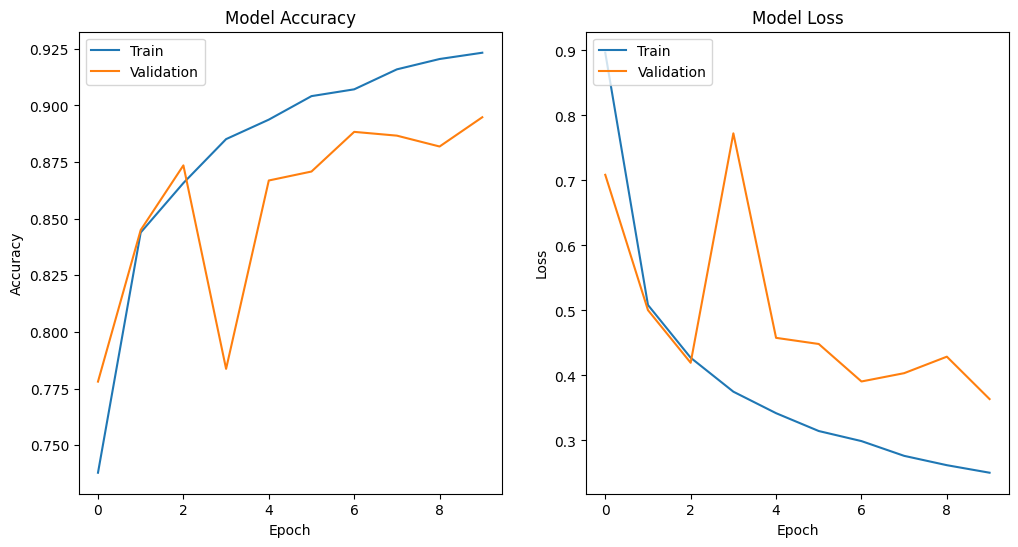

In [ ]:
plt.figure(figsize=(12, 6)) # Creates a new figure for plotting with a width of 12 inches and a height of 6 inches.
plt.subplot(1, 2, 1) # This function divides the figure into a 1x2 grid (1 row, 2 columns) and creates a subplot in the first column. This is where the accuracy plot will be drawn.
plt.plot(history.history['accuracy']) # These lines plot the training accuracy ('accuracy') and validation accuracy ('val_accuracy') from the history object. history.history is a dictionary containing the training and validation metrics after each epoch.
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy') # These lines set the title of the plot, and the labels for the y-axis and x-axis respectively.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left') # Adds a legend to the plot with the labels 'Train' and 'Validation', located in the upper left corner of the plot.

plt.subplot(1, 2, 2) # This function creates a subplot in the second column of the 1x2 grid for the loss plot.
plt.plot(history.history['loss']) # These lines plot the training loss ('loss') and validation loss ('val_loss') from the history object.
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show() # Finally, this function displays the figure with the two subplots.

# **Step 6. Evaluate and Use the Model**



In [ ]:
import numpy as np

# In general, the goal of learning any topic is to simply do things. 
# Therefore, the goal of learning NumPy is to acquire the necessary information to speed up calculations related to arrays and matrices. 
# On the other hand, this library helps you to perform the calculations related to machine learning more accurately and to be more sure of the intended output.

In [ ]:
# Evaluate the model on your validation/test set. 
# Adjust training (like changing learning rates, adding dropout, or more data augmentation) based on the evaluation. 
# Predict new images for classification.

evaluation = model.evaluate(validation_generator) # model.evaluate computes the loss and any other metrics specified during model compilation (in your case, accuracy) on the validation set. validation_generator is used to provide the validation data. The result, evaluation, is a list containing the loss as its first element and accuracy as the second.
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}") # This line prints the validation loss and accuracy, using Python's f-string for formatted output.

def predict_image(image_path): # a function defined to predict the class of an image specified by image_path.
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# Inside predict_image:
# img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299)) loads the image from image_path and resizes it to 299x299 pixels, which is the input size expected by InceptionV3.
# img_array = tf.keras.preprocessing.image.img_to_array(img) converts the PIL Image to a NumPy array.
# img_array = tf.expand_dims(img_array, 0) adds an extra dimension to the array to represent the batch size, as the model expects batches of images.
# img_array = tf.keras.applications.inception_v3.preprocess_input(img_array) preprocesses the image array by scaling the pixel values in a way that the InceptionV3 model expects.
# predictions = model.predict(img_array) uses the model to make predictions on the preprocessed image.
# predicted_class = np.argmax(predictions, axis=1) finds the class with the highest predicted probability.

class_idx = predict_image('/content/test/test/1400Ripples/L1_4PDXlSyAbc_spectrogram_0.5.png') # This line calls the predict_image function with a specified image path and stores the predicted class index in class_idx.

150/150 [==============================] - 55s 367ms/step - loss: 0.3636 - accuracy: 0.8948
Validation Loss: 0.36358898878097534, Validation Accuracy: 0.8947916626930237
1/1 [==============================] - 0s 26ms/step


# **Step 7. Fine-Tuning**


In [ ]:
# Once your model has initially trained, you can fine-tune by unfreezing the top layers of the InceptionV3 model and continue training. 
# This step requires a lower learning rate to avoid damaging the pretrained weights.

base_model.trainable = True # This line sets the trainable attribute of the base_model to True. Remember that base_model is your InceptionV3 model. Initially, you had frozen the layers of base_model (by setting their trainable attribute to False) for the first phase of training. By setting trainable to True, all layers in the base_model are now unfrozen and can be updated during training.

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# The model is recompiled with an optimizer, loss function, and metrics. This is necessary after making changes to the trainable status of any layer in the model.
# optimizer=tf.keras.optimizers.Adam(1e-5): The Adam optimizer is used with a very low learning rate (1e-5). This smaller learning rate helps in fine-tuning because you typically want to make smaller adjustments to the model, not to overwrite its previously learned patterns.
# loss='categorical_crossentropy' and metrics=['accuracy']: These are the same loss function and metric used earlier.

fine_tune_epochs = 10 # This sets the number of epochs for the fine-tuning phase to 10.

history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=validation_generator
)

# The model is trained again using the fit method. This time, the entire model, including the previously frozen base model layers, is being trained.
# train_generator and validation_generator are used again for training and validation data.
# epochs=fine_tune_epochs indicates that the training will proceed for the number of epochs specified in fine_tune_epochs.


Epoch 1/10
699/699 [==============================] - 467s 606ms/step - loss: 0.8531 - accuracy: 0.7646 - val_loss: 0.3149 - val_accuracy: 0.9067
Epoch 2/10
699/699 [==============================] - 375s 536ms/step - loss: 0.2365 - accuracy: 0.9294 - val_loss: 0.2251 - val_accuracy: 0.9350
Epoch 3/10
699/699 [==============================] - 373s 534ms/step - loss: 0.1460 - accuracy: 0.9564 - val_loss: 0.1922 - val_accuracy: 0.9442
Epoch 4/10
699/699 [==============================] - 374s 535ms/step - loss: 0.0939 - accuracy: 0.9732 - val_loss: 0.1840 - val_accuracy: 0.9504
Epoch 5/10
699/699 [==============================] - 375s 536ms/step - loss: 0.0694 - accuracy: 0.9800 - val_loss: 0.1862 - val_accuracy: 0.9550
Epoch 6/10
699/699 [==============================] - 375s 536ms/step - loss: 0.0509 - accuracy: 0.9874 - val_loss: 0.1990 - val_accuracy: 0.9488
Epoch 7/10
699/699 [==============================] - 375s 536ms/step - loss: 0.0453 - accuracy: 0.9880 - val_loss: 0.1832 -

# **Part II**
# **EfficientNet**

# **Step 1. import the necessary modules in your Google Colab notebook**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # or another version of EfficientNet
from tensorflow.keras import layers, models

# **Step 2. Data Preprocessing**



In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

train_data_dir = '/content/train/train'
validation_data_dir = '/content/validation/validation'

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Default size for EfficientNetB0
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 17887 images belonging to 22 classes.
Found 950 images belonging to 22 classes.


# **Step 3. Load EfficientNet Model**



In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


# **Step 4. Add Custom Layers**



In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(22, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

# **Step 5. Compile the Model**



In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **Step 6. Train the Model**



In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10
559/559 [==============================] - 218s 370ms/step - loss: 0.7192 - accuracy: 0.7849 - val_loss: 0.5644 - val_accuracy: 0.8158
Epoch 2/10
559/559 [==============================] - 181s 324ms/step - loss: 0.4483 - accuracy: 0.8615 - val_loss: 0.5298 - val_accuracy: 0.8211
Epoch 3/10
559/559 [==============================] - 177s 317ms/step - loss: 0.3825 - accuracy: 0.8819 - val_loss: 0.4601 - val_accuracy: 0.8463
Epoch 4/10
559/559 [==============================] - 173s 309ms/step - loss: 0.3412 - accuracy: 0.8913 - val_loss: 0.4196 - val_accuracy: 0.8695
Epoch 5/10
559/559 [==============================] - 174s 311ms/step - loss: 0.3101 - accuracy: 0.9009 - val_loss: 0.3910 - val_accuracy: 0.8779
Epoch 6/10
559/559 [==============================] - 174s 311ms/step - loss: 0.2904 - accuracy: 0.9079 - val_loss: 0.4111 - val_accuracy: 0.8653
Epoch 7/10
559/559 [==============================] - 173s 310ms/step - loss: 0.2703 - accuracy: 0.9148 - val_loss: 0.4280 -

In [ ]:
import matplotlib.pyplot as plt

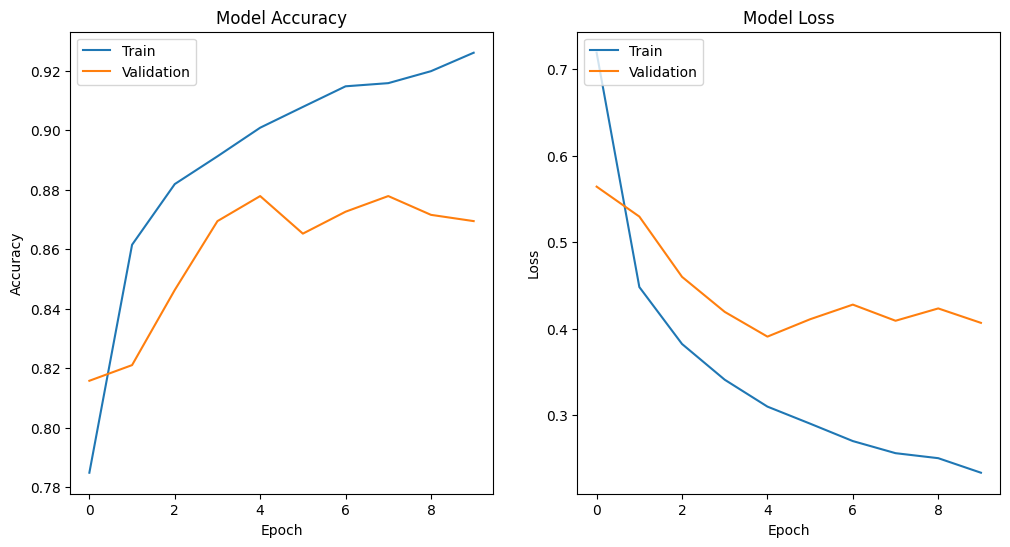

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# **Step 7. Fine-Tuning**



In [ ]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 10

history_fine = model.fit(train_generator,
                         epochs=fine_tune_epochs,
                         validation_data=validation_generator)

Epoch 1/10
559/559 [==============================] - 242s 367ms/step - loss: 3.7201 - accuracy: 0.5037 - val_loss: 1.4512 - val_accuracy: 0.6758
Epoch 2/10
559/559 [==============================] - 206s 368ms/step - loss: 1.1368 - accuracy: 0.7315 - val_loss: 0.8604 - val_accuracy: 0.7842
Epoch 3/10
559/559 [==============================] - 203s 363ms/step - loss: 0.7539 - accuracy: 0.7983 - val_loss: 0.6409 - val_accuracy: 0.8168
Epoch 4/10
559/559 [==============================] - 206s 367ms/step - loss: 0.5666 - accuracy: 0.8377 - val_loss: 0.5302 - val_accuracy: 0.8421
Epoch 5/10
559/559 [==============================] - 204s 364ms/step - loss: 0.4654 - accuracy: 0.8630 - val_loss: 0.4586 - val_accuracy: 0.8642
Epoch 6/10
559/559 [==============================] - 204s 365ms/step - loss: 0.3668 - accuracy: 0.8905 - val_loss: 0.4280 - val_accuracy: 0.8789
Epoch 7/10
559/559 [==============================] - 203s 362ms/step - loss: 0.3230 - accuracy: 0.9017 - val_loss: 0.3779 -

# **Step 8. Model Evaluation and Prediction**



In [ ]:
import numpy as np

In [ ]:
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}")

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

class_idx = predict_image('/content/test/test/Helix/L1_2xHIwtBr1N_spectrogram_4.0.png')

30/30 [==============================] - 8s 278ms/step - loss: 0.3268 - accuracy: 0.9042
Validation Loss: 0.32677963376045227, Validation Accuracy: 0.9042105078697205
1/1 [==============================] - 0s 38ms/step
